This reads in the `output.xls` file from the modelComparer script, and creates various plots comparing H abstraction by OOH radical rates from the AutoTST library with all the other libraries.

In [1]:
import matplotlib
#matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import cPickle as pickle
import re

import numpy as np
import os, sys
rmg_path = os.getenv('RMGpy')
if rmg_path and rmg_path not in sys.path:
    sys.path.insert(1,rmg_path)

import rmgpy.kinetics
from rmgpy.molecule import Molecule
from rmgpy.reaction import Reaction
from collections import defaultdict, OrderedDict

In [2]:
with open("rateCoefficients.plk", "r") as f:
    rateCoeff = pickle.load(f)


rateCoeff.loc['AutoTST-OOH'] = np.nan
rateCoeff

,c4h7oh1-4 + o2 <=> c4h6oh1-32 + ho2,IC8KETBD => CH2O + TC4H9COC2H4S + OH,IC4H9T + C4H9CHO => IC4H10 + C3H6 + CH2CHO,C5H7 + C4H9CHO => C5H8 + C3H6 + CH2CHO,HCO3 + C4H9CHO => HCO3H + C3H6 + CH2CHO,IC8H18 + NC7H15 <=> NEOC7H16 + DC8H17,X135C6H8 + CH3 <=> CEC7H11A,CH3CO3 + C4H9CHO => CH3CO3H + C3H6 + CH2CHO,nc8h17cho + o2 <=> nc8h17co + ho2,NC3H7OO + C4H9CHO => C3H7OOH + C3H6 + CH2CHO,...,C6H6 + O <=> C6H5O + H,R114C10H21O2P <=> R121C10H21O2P,C7H12-15 <=> aC3H5 + SAXC4H7,c4h6 + c4h7-3 <=> ic4h5 + c4h8-1,C6H6 + OH <=> C6H5 + H2O,ch3coch2o <=> ch3co + ch2o,IC4P-QOOH => IC4H9P-OO,IC4H9T-OO => IC4T-QOOH,NC11H24 + O2 <=> C11H23-6 + HO2,sC3H5 + O2 <=> CH3CO + CH2O
AramcoMech_1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AramcoMech_2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.626971,NaN,NaN,NaN,14.840077,25.790881,NaN,NaN,NaN,NaN
Biomass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chernov,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.626553,NaN,NaN,NaN,14.229660,NaN,NaN,NaN,NaN,NaN
CombFlame2012/2028-Sarathy,-3.107443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/1315-Chang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/1541-Zhang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,23.651811,NaN,NaN,NaN,NaN
CombFlame2013/1609-Veloo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/17-Malewicki,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.840077,NaN,NaN,NaN,-8.425188,NaN
CombFlame2013/1939-Cai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.626971,NaN,NaN,NaN,14.388805,NaN,NaN,NaN,NaN,NaN


In [3]:
with open("kinetics.pkl", "r") as f:
    importerKinetics = pickle.load(f)

    
importerKinetics

{Reaction(reactants=[Species(label="C3H5-A", molecule=[Molecule(SMILES="[CH2]C=C")]), Species(label="CH3O2", molecule=[Molecule(SMILES="CO[O]")])], products=[Species(label="C3H5O", molecule=[Molecule(SMILES="C=CC[O]")]), Species(label="CH3O", molecule=[Molecule(SMILES="C[O]")])]): {'AramcoMech_1.3': Arrhenius(A=(7e+12,'cm^3/(mol*s)'), n=0, Ea=(-1000,'cal/mol'), T0=(1,'K')),
  'AramcoMech_2.0': PDepArrhenius(pressures=([0.01,0.1,1,10,100],'atm'), arrhenius=[Arrhenius(A=(3.33e+12,'cm^3/(mol*s)'), n=-0.158, Ea=(-1417,'cal/mol'), T0=(1,'K')), Arrhenius(A=(1.66e+14,'cm^3/(mol*s)'), n=-0.642, Ea=(-349.1,'cal/mol'), T0=(1,'K')), Arrhenius(A=(2.595e+17,'cm^3/(mol*s)'), n=-1.52, Ea=(2379.2,'cal/mol'), T0=(1,'K')), Arrhenius(A=(9.78e+14,'cm^3/(mol*s)'), n=-0.684, Ea=(3615.3,'cal/mol'), T0=(1,'K')), Arrhenius(A=(5470,'cm^3/(mol*s)'), n=2.74, Ea=(1144.4,'cal/mol'), T0=(1,'K'))]),
  'CombFlame2012/2028-Sarathy': Arrhenius(A=(7e+12,'cm^3/(mol*s)'), n=0, Ea=(-1000,'cal/mol'), T0=(1,'K')),
  'CombFlam

In [4]:
def evalArrhenius(autoTSTExpression):
    if autoTSTExpression is np.nan:
        return autoTSTExpression
    try:
        my_string = str(autoTSTExpression).strip("'")
        print my_string
        result = eval(my_string, {}, {'Arrhenius': rmgpy.kinetics.Arrhenius,
                                     'MultiArrhenius': rmgpy.kinetics.MultiArrhenius,
                                     'PDepArrhenius': rmgpy.kinetics.PDepArrhenius,})
    except:
        result = autoTSTExpression
        raise
    return result

def RateCoefficients(arrhenius):
    rate = np.nan
    try:
        rate = arrhenius.getRateCoefficient(T=1000, P=1e5)
        print "Rate Calculated"
    except:
        print "No rate to calculate"
        pass
    return rate

In [5]:
directory = '/gss_gpfs_scratch/harms.n/comparerTST'
results = defaultdict(OrderedDict)
comparerFiles = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
k = 0
for fil in comparerFiles:
    if ".log" and "updated" in fil:
        k += 1
print k
results = defaultdict(OrderedDict)
not_ooh_abstraction = []
autoTST = {}
for i in range(1,k+1):
    r = results[i]
    filename = 'AutoTST-comparer.updated.{0:d}.combined.log'.format(i)
    filepath = os.path.join(directory,filename)
    with open(filepath) as f:
        lines = f.readlines()
    
    for j,l in enumerate(lines):
        m = re.match('comparerTST.py:182 performCalcs INFO reaction: (.*)', l)
        n = re.match('comparerTST.py:221 performCalcs INFO We have calculated kinetics (.*)', l)
        if m:
            r['Reaction'] = eval(m.group(1))
        if n:
            r["AutoTST Kinetics"] = np.log(evalArrhenius(n.group(1)).getRateCoefficient(T=1000, P=1e5))

    if "Reaction" in r.keys() and "AutoTST Kinetics" in r.keys():
        autoTST[r['Reaction']] = r["AutoTST Kinetics"]
        

623
Arrhenius(A=(0.265705,'cm^3/(mol*s)'), n=3.96021, Ea=(92.4156,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.08257, dn = +|- 0.0104122, dEa = +|- 0.0572774 kJ/mol""")
Arrhenius(A=(9.59731e-06,'cm^3/(mol*s)'), n=4.88218, Ea=(7.73744,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.80424, dn = +|- 0.0774509, dEa = +|- 0.426057 kJ/mol""")
Arrhenius(A=(4.25716e-06,'cm^3/(mol*s)'), n=5.20307, Ea=(21.3304,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.04573, dn = +|- 0.0939363, dEa = +|- 0.516744 kJ/mol""")
Arrhenius(A=(0.00263746,'cm^3/(mol*s)'), n=3.97659, Ea=(-1.62058,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.12702, dn = +|- 0.0156938, dEa = +|- 0.0863314 kJ/mol""")
Arrhenius(A=(0.00110227,'cm^3/(mol*s)'), n=4.64487, Ea=(58.9253,'kJ/mol'), T0=(1,

In [6]:
for key in rateCoeff.keys():
    if len(key.reactants) == 2 and len(key.products) == 2:
        reacts = []
        for reactant in key.reactants:
            reacts.append(reactant.molecule[0])
        for autoTSTKey in autoTST.keys():
            if autoTSTKey.matchesMolecules(reacts):
                print "Match found"
                print autoTST[autoTSTKey]
                print
                rateCoeff[key].loc["AutoTST-OOH"] = autoTST[autoTSTKey]

Match found
3.86148436037

Match found
3.86148436037

Match found
3.86148436037

Match found
5.17836645421

Match found
8.46545897396

Match found
5.17836645421

Match found
5.17836645421

Match found
3.7147133103

Match found
4.95221064718

Match found
4.95221064718

Match found
5.71627490165

Match found
5.71627490165

Match found
5.71627490165

Match found
5.71627490165

Match found
4.31156333872

Match found
4.31156333872

Match found
4.31156333872

Match found
4.31156333872

Match found
4.31156333872

Match found
4.31156333872

Match found
4.31156333872

Match found
4.31156333872

Match found
4.31156333872

Match found
9.91895939753

Match found
7.91077181391

Match found
4.37265450983

Match found
3.39530025428

Match found
7.97491720024

Match found
3.66995843137

Match found
3.66995843137

Match found
3.66995843137

Match found
3.66995843137

Match found
1.10025305449

Match found
6.85435228666

Match found
4.80533306712

Match found
6.88723144526

Match found
6.88723144526

Ma

In [7]:
rateCoeff

,c4h7oh1-4 + o2 <=> c4h6oh1-32 + ho2,IC8KETBD => CH2O + TC4H9COC2H4S + OH,IC4H9T + C4H9CHO => IC4H10 + C3H6 + CH2CHO,C5H7 + C4H9CHO => C5H8 + C3H6 + CH2CHO,HCO3 + C4H9CHO => HCO3H + C3H6 + CH2CHO,IC8H18 + NC7H15 <=> NEOC7H16 + DC8H17,X135C6H8 + CH3 <=> CEC7H11A,CH3CO3 + C4H9CHO => CH3CO3H + C3H6 + CH2CHO,nc8h17cho + o2 <=> nc8h17co + ho2,NC3H7OO + C4H9CHO => C3H7OOH + C3H6 + CH2CHO,...,C6H6 + O <=> C6H5O + H,R114C10H21O2P <=> R121C10H21O2P,C7H12-15 <=> aC3H5 + SAXC4H7,c4h6 + c4h7-3 <=> ic4h5 + c4h8-1,C6H6 + OH <=> C6H5 + H2O,ch3coch2o <=> ch3co + ch2o,IC4P-QOOH => IC4H9P-OO,IC4H9T-OO => IC4T-QOOH,NC11H24 + O2 <=> C11H23-6 + HO2,sC3H5 + O2 <=> CH3CO + CH2O
AramcoMech_1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AramcoMech_2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.626971,NaN,NaN,NaN,14.840077,25.790881,NaN,NaN,NaN,NaN
Biomass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chernov,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.626553,NaN,NaN,NaN,14.229660,NaN,NaN,NaN,NaN,NaN
CombFlame2012/2028-Sarathy,-3.107443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/1315-Chang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/1541-Zhang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,23.651811,NaN,NaN,NaN,NaN
CombFlame2013/1609-Veloo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/17-Malewicki,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.840077,NaN,NaN,NaN,-8.425188,NaN
CombFlame2013/1939-Cai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.626971,NaN,NaN,NaN,14.388805,NaN,NaN,NaN,NaN,NaN


In [8]:
rcopy = rateCoeff

newRateCoeff = rcopy[rcopy.loc["AutoTST-OOH"].dropna().keys()]
newRateCoeff
        

,HCOCH2OCHO + HO2 <=> COCH2OCHO + H2O2,C5H10-2 + HO2 <=> C5H11-3 + O2,mb3d + ho2 <=> c5h7o2 + h2o2,C4H10O + HO2 <=> C4H9Oa + H2O2,toluene + R3OOH <=> C6H4CH3 + H2O2,THP + HO2 <=> THP-4-yl + H2O2,THP + HO2 <=> THP-3-yl + H2O2,THP + HO2 <=> THP-2-yl + H2O2,HCCO + H2O2 => CH2CO + HO2,C2H5 + H2O2 <=> C2H6 + HO2,...,c4h7oh1-4 + ho2 <=> c4h6oh1-32 + h2o2,IC4H9P + H2O2 => IC4H10 + HO2,c4h7oh1-2 + ho2 <=> c4h6oh1-32 + h2o2,CC5H10 + HO2 <=> CC5H9-A + H2O2,evk + ho2 <=> evjk-p + h2o2,HO2 + IC3H5CHO => CO + NC3-QOOH,HO2 + CH3OOH => H2O2 + CH3OO,THP-3-ene + HO2 <=> THP-345-enyl + H2O2,THP-3-ene + HO2 <=> THP-234-enyl + H2O2,BC5H10 + HO2 <=> CC5H9-B + H2O2
AramcoMech_1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AramcoMech_2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.417166,NaN,NaN,NaN,NaN,NaN,6.318450
Biomass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.465320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chernov,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2012/2028-Sarathy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.980899,NaN,7.447748,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/1315-Chang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/1541-Zhang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/1609-Veloo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.580943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/17-Malewicki,NaN,NaN,NaN,NaN,-1.827130,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/1939-Cai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.580943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Making the box plot

In [9]:
rxnList = rateCoeff.loc['AutoTST-OOH'].dropna().keys()
kinSheet = rateCoeff[rxnList].T.sort_values(by='AutoTST-OOH').T
kSheet = kinSheet.iloc[:-1,:] # remove the last column, which is AutoTST-OOHabstraction
kinSheet

,c3h6o1-3 + ho2 => h2o2 + pc2h4cho,ch3ch2o + ho2 <=> ch3cho + h2o2,C2H3OH + HO2 <=> HCCHOH + H2O2,C2H3OH + HO2 <=> CH2CHO + H2O2,C2H3OH + HO2 <=> CH2COH + H2O2,C2H3OH + HO2 <=> CH3CHO + HO2,R3OOH + C2H4Z <=> CH3CHO + R2OH,C2H4 + HO2 <=> C2H5 + O2,HO2 + C2H4 => H2O2 + C2H3,C2H4 + HO2 <=> C2H4O1-2 + OH,...,C3H8 + HO2 <=> NC3H7 + H2O2,ic3h7coch3 + ho2 <=> tc3h6coch3 + h2o2,TC3H6COCH3 + H2O2 <=> IC3H7COCH3 + HO2,ic3h7coch3 + ho2 <=> ic3h6coch3 + h2o2,ic3h7coch3 + ho2 <=> ic3h7coch2 + h2o2,ic3h7coch3 + ho2 <=> tc3h6coch3 + h2o2,C5H92-5 + H2O2 => C5H10-2 + HO2,HCCO + H2O2 => CH2CO + HO2,HO2 + CH2CO => H2O2 + HCCO,CH2-5-cC6H6-13 + HO2 <=> A1CH2 + H2O2
AramcoMech_1.3,NaN,NaN,NaN,NaN,NaN,6.205221,NaN,NaN,NaN,4.580884,...,6.056776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AramcoMech_2.0,NaN,NaN,NaN,NaN,NaN,6.205221,NaN,NaN,NaN,6.372643,...,6.056776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Biomass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.787453,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chernov,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2012/2028-Sarathy,NaN,NaN,NaN,NaN,NaN,6.205221,NaN,NaN,NaN,4.580884,...,6.056776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/1315-Chang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/1541-Zhang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.967178,...,6.357358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/1609-Veloo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.271773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/17-Malewicki,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.967178,...,6.357358,NaN,NaN,6.217670,5.531795,5.291412,NaN,NaN,NaN,NaN
CombFlame2013/1939-Cai,NaN,NaN,6.631301,6.631301,6.631301,15.227862,NaN,NaN,NaN,6.247203,...,6.056776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/shared/apps/python/Python-2.7.5/INSTALL/lib/python2.7/site-packages/numpy-1.11.2-py2.7-linux-x86_64.egg/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


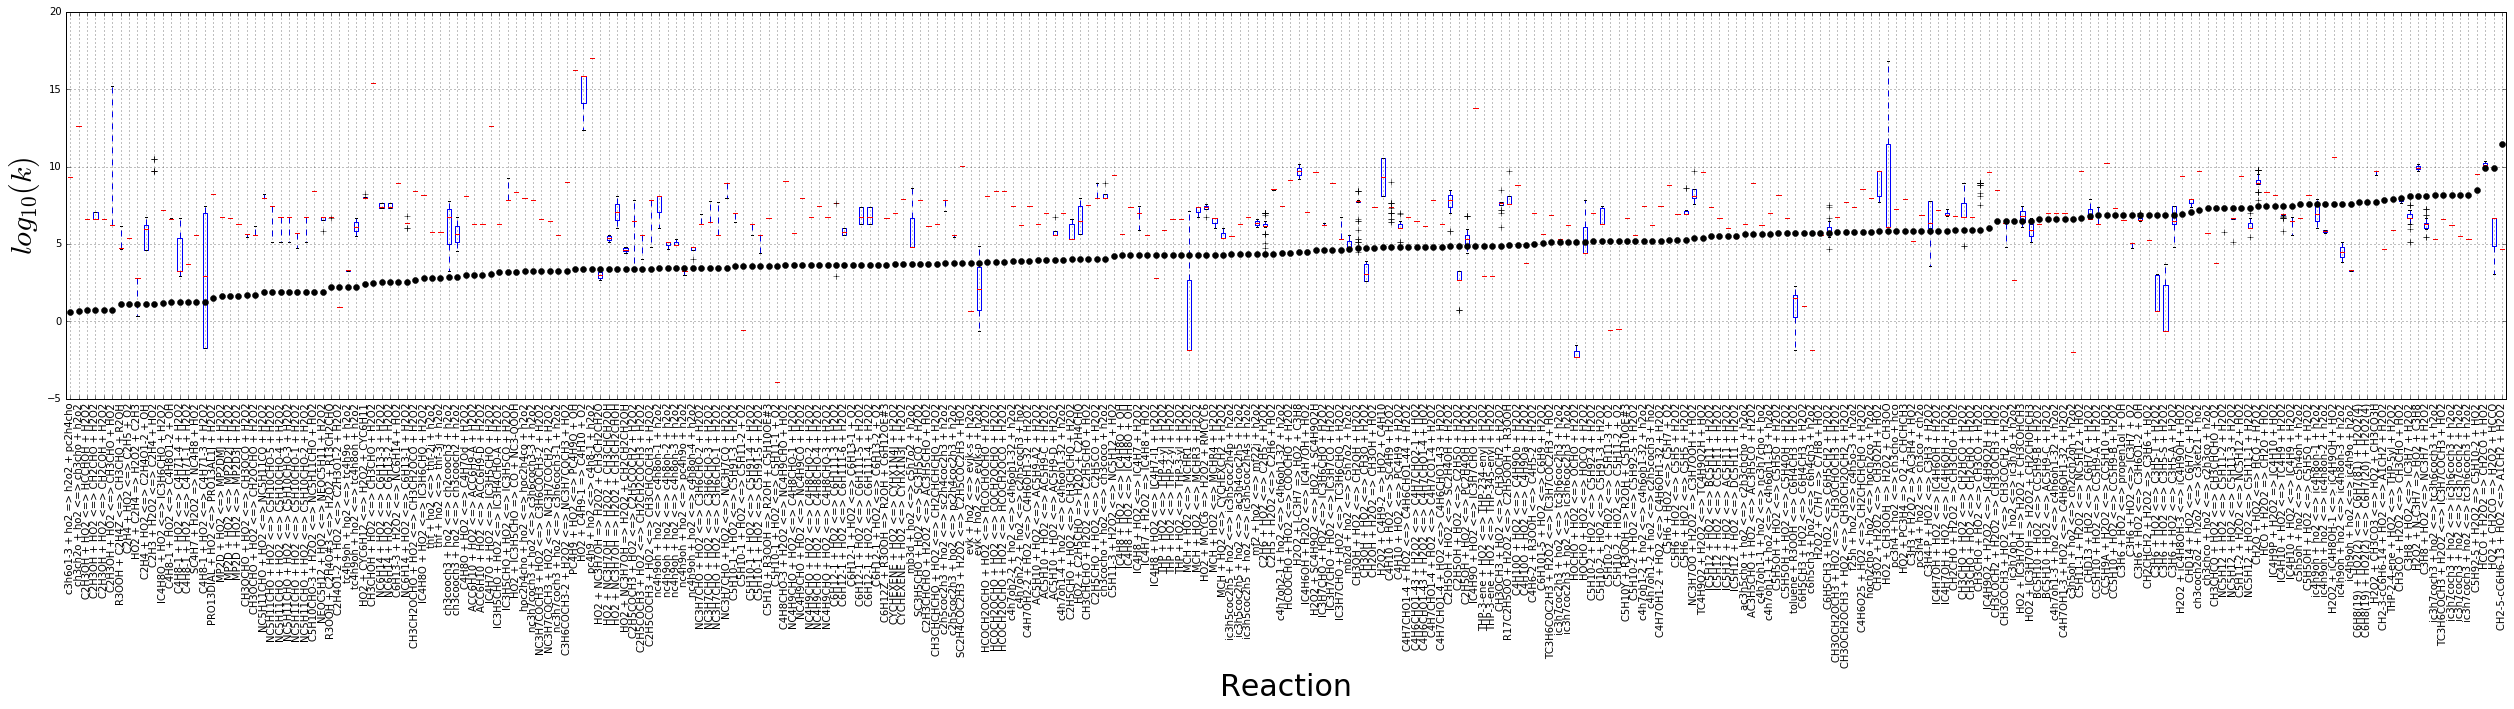

In [10]:
boxPlot = kSheet.plot.box(figsize=(35,10), grid=True, rot=90)
boxPlot.plot(range(1,kinSheet.shape[1]+1),kinSheet.transpose()['AutoTST-OOH'].values, marker='o', color='k', linestyle='')

boxPlot.set_ylabel('$log_{10}(k)$', fontsize=30)
boxPlot.set_xlabel('Reaction', fontsize=30)
boxPlot.set_ylim((-5,20)) # This cuts out the -70 results 

fig = boxPlot.get_figure()
fig.tight_layout()
fig.savefig("boxPlot.pdf")


## Making the parity plot

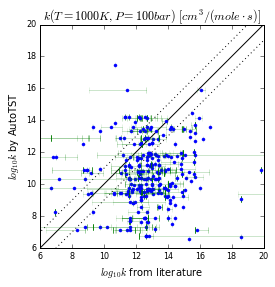

In [11]:
plt.plot(range(-2, 25), range(-2, 25), '-k', zorder=-1) # Parity Line
plt.plot(range(-3, 24), range(-2, 25), ':k', zorder=-1) # 1 order of magnitude
plt.plot(range(-1, 26), range(-2, 25), ':k', zorder=-1) # 1 order of magnitude

for j in kinSheet.T.index:
    mean = kSheet[j].mean() + 6 # ksheet excludes AutoTST
    autoTST = kinSheet[j].loc['AutoTST-OOH'] + 6
    x_list = []
    y_list = []
    for i in list(kinSheet.T):
        if i != "AutoTST-OOH" and not pd.isnull(kinSheet[j].loc[i]):
            x_list.append(kinSheet[j].loc[i] + 6)
            y_list.append(autoTST)

    plt.plot(x_list, y_list, '|-g', alpha=0.2) # Line and dots for the range of literature values
    #plt.plot(x_list, y_list, '|b') # Tick marks for each point
    plt.plot(mean, autoTST, '.b') # Red bars for the average

    plt.axis('equal')
    plt.ylim([6,20])
    plt.xlim([6,20])
    plt.title("$k(T=1000 K, P=100 bar) \ [cm^3 / (mole \cdot s)]$")
    plt.xlabel('$log_{10}k$ from literature', fontsize=10)
    plt.ylabel('$log_{10}k$ by AutoTST', fontsize=10)
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)
    plt.axes().set_aspect('equal',adjustable='box')
    


plt.savefig('parityPlot.pdf')

Trying to debug the `ValueError` on `not pd.isnull(kinSheet[i].loc[j])` which suggests `kinSheet[i].loc[j]` is a Series not a single value

In [12]:
# See what i,j and the value is:
print i,j
kinSheet[i].loc[j]

AutoTST-OOH CH2-5-cC6H6-13 + HO2 <=> A1CH2 + H2O2


KeyError: 'AutoTST-OOH'

In [ ]:
kinSheet.loc[j]

There are two reactions that look the same!
Looking into the `AutoTST-OOHabstraction` Reaction Library it looks like there are two different species being given the same name `IC4H6OH` in the spreadsheet.

## IC4H7OH + HO2 <=> IC4H6OH + H2O2
```
AutoTST-OOHabstraction Arrhenius(A=(8.37166e-09,'cm^3/(mol*s)'), n=5.75426, Ea=(31.1394,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.74682, dn = +|- 0.132612, dEa = +|- 0.729496 kJ/mol""")
Gasoline_Surrogate Arrhenius(A=(7644,'cm^3/(mol*s)'), n=2.712, Ea=(13930,'cal/mol'), T0=(1,'K'))
n-Heptane Arrhenius(A=(7644,'cm^3/(mol*s)'), n=2.712, Ea=(13930,'cal/mol'), T0=(1,'K'))
PCI2013/335-Wang Arrhenius(A=(7644,'cm^3/(mol*s)'), n=2.712, Ea=(13930,'cal/mol'), T0=(1,'K'))
MB-Dooley Arrhenius(A=(7644,'cm^3/(mol*s)'), n=2.71, Ea=(13930,'cal/mol'), T0=(1,'K'))
CombFlame2013/487-Schenk Arrhenius(A=(792.2,'cm^3/(mol*s)'), n=2.98, Ea=(12300,'cal/mol'), T0=(1,'K'))
AramcoMech_2.0 Arrhenius(A=(1.45e-05,'cm^3/(mol*s)'), n=5.26, Ea=(8267.91,'cal/mol'), T0=(1,'K'))
CombFlame2013/1541-Zhang Arrhenius(A=(7644,'cm^3/(mol*s)'), n=2.712, Ea=(13930,'cal/mol'), T0=(1,'K'))
```
In `AutoTST-OOHabstraction` this is:
```
entry(
    index = 162,
    label = "C4H8O(189) + HO2(2) <=> H2O2(4) + C4H7O(259)",
    degeneracy = 1,
    kinetics =  Arrhenius(
        A = (8.37166e-09, 'cm^3/(mol*s)'),
        n = 5.75426,
        Ea = (31.1394, 'kJ/mol'),
        T0 = (1, 'K'),
        Tmin = (303.03, 'K'),
        Tmax = (2500, 'K'),
        comment = 'Fitted to 59 data points; dA = *|/ 2.74682, dn = +|- 0.132612, dEa = +|- 0.729496 kJ/mol',
    ),
    shortDesc = u"""AutoTST M062X for C4H8O(189) + HO2(2) <=> H2O2(4) + C4H7O(259)""",
)
```
and `C4H7O(259)` is 
```
C4H7O(259)
multiplicity 2
1  C u0 p0 c0 {2,S} {5,S} {6,S} {7,S}
2  C u0 p0 c0 {1,S} {3,S} {4,D}
3  C u1 p0 c0 {2,S} {8,S} {9,S}
4  C u0 p0 c0 {2,D} {10,S} {11,S}
5  O u0 p2 c0 {1,S} {12,S}
6  H u0 p0 c0 {1,S}
7  H u0 p0 c0 {1,S}
8  H u0 p0 c0 {3,S}
9  H u0 p0 c0 {3,S}
10 H u0 p0 c0 {4,S}
11 H u0 p0 c0 {4,S}
12 H u0 p0 c0 {5,S}

InChI:	InChI=1S/C4H7O/c1-4(2)3-5/h5H,1-3H2
SMILES:	[CH2]C(=C)CO
```

## IC4H7OH + HO2 <=> IC4H6OH + H2O2
```
AutoTST-OOHabstraction Arrhenius(A=(8.04843e-06,'cm^3/(mol*s)'), n=4.79274, Ea=(14.1732,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.74322, dn = +|- 0.0729353, dEa = +|- 0.401217 kJ/mol""")
PCI2017/052-Li Arrhenius(A=(1.45e-05,'cm^3/(mol*s)'), n=5.26, Ea=(8267.91,'cal/mol'), T0=(1,'K'))
```
In `AutoTST-OOHabstraction` this is:
```
entry(
    index = 112,
    label = "C4H8O(189) + HO2(2) <=> C4H7O(190) + H2O2(4)",
    degeneracy = 1,
    kinetics =  Arrhenius(
        A = (8.04843e-06, 'cm^3/(mol*s)'),
        n = 4.79274,
        Ea = (14.1732, 'kJ/mol'),
        T0 = (1, 'K'),
        Tmin = (303.03, 'K'),
        Tmax = (2500, 'K'),
        comment = 'Fitted to 59 data points; dA = *|/ 1.74322, dn = +|- 0.0729353, dEa = +|- 0.401217 kJ/mol',
    ),
    shortDesc = u"""AutoTST M062X for C4H8O(189) + HO2(2) <=> C4H7O(190) + H2O2(4)""",
)
```
and `C4H7O(190)` is 
```
C4H7O(190)
multiplicity 2
1  C u0 p0 c0 {2,S} {6,S} {7,S} {8,S}
2  C u0 p0 c0 {1,S} {3,S} {4,D}
3  C u1 p0 c0 {2,S} {5,S} {9,S}
4  C u0 p0 c0 {2,D} {10,S} {11,S}
5  O u0 p2 c0 {3,S} {12,S}
6  H u0 p0 c0 {1,S}
7  H u0 p0 c0 {1,S}
8  H u0 p0 c0 {1,S}
9  H u0 p0 c0 {3,S}
10 H u0 p0 c0 {4,S}
11 H u0 p0 c0 {4,S}
12 H u0 p0 c0 {5,S}

InChI:	InChI=1S/C4H7O/c1-4(2)3-5/h3,5H,1H2,2H3
SMILES:	C=C(C)[CH]O
```

The InChI codes are different so they're not resonance isomers.  So I think it's a bug that the model comparer is giving them the same name. Let's load the names pickle and see if we can find them

In [ ]:
import cPickle as pickle
names = pickle.load(open('../names.pkl'))
names = pd.DataFrame(names)
names.columns = [n.toSMILES() for n in names.columns]
names.index = [n.split('RMG-models/')[-1] for n in names.index]
names

In [ ]:
print names.index
'AutoTST-OOHabstraction' in names.index

Dang!

## Making the Arrhenius plots for each reaction

In [ ]:
importerKin = pd.DataFrame(importerKinetics).drop("AutoTST-OOHabstraction")
importerKin.loc['AutoTST-OOH'] = np.nan
importerKin 

In [ ]:
directory = '/gss_gpfs_scratch/harms.n/comparerTST'
results = defaultdict(OrderedDict)
comparerFiles = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
k = 0
for fil in comparerFiles:
    if ".log" and "updated" in fil:
        k += 1
print k
results = defaultdict(OrderedDict)
not_ooh_abstraction = []
autoTST = {}
for i in range(1,k+1):
    r = results[i]
    filename = 'AutoTST-comparer.updated.{0:d}.combined.log'.format(i)
    filepath = os.path.join(directory,filename)
    with open(filepath) as f:
        lines = f.readlines()
    
    for j,l in enumerate(lines):
        m = re.match('comparerTST.py:182 performCalcs INFO reaction: (.*)', l)
        n = re.match('comparerTST.py:221 performCalcs INFO We have calculated kinetics (.*)', l)
        if m:
            r['Reaction'] = eval(m.group(1))
        if n:
            r["AutoTST Arrhenius"] = evalArrhenius(n.group(1))

    if "Reaction" in r.keys() and "AutoTST Arrhenius" in r.keys():
        autoTST[r['Reaction']] = r["AutoTST Arrhenius"]
        

In [ ]:
for key in importerKin.keys():
    if len(key.reactants) == 2 and len(key.products) == 2:
        reacts = []
        for reactant in key.reactants:
            reacts.append(reactant.molecule[0])
        for autoTSTKey in autoTST.keys():
            if autoTSTKey.matchesMolecules(reacts):
                print "Match found"
                print autoTST[autoTSTKey]
                print
                importerKin[key].loc["AutoTST-OOH"] = autoTST[autoTSTKey]

In [ ]:
importerKin

In [ ]:
rxnList = importerKin.T['AutoTST-OOH'].dropna(axis=0).index.values
expSheet = importerKin[rxnList].T.sort_values(by='AutoTST-OOH')
expSheet

In [ ]:
#%cd arrheniusPlots

In [ ]:
def evalArrhenius(autoTSTExpression):
    if autoTSTExpression is np.nan:
        return autoTSTExpression
    try:
        my_string = str(autoTSTExpression).strip("'")
        print my_string
        result = eval(my_string, {}, {'Arrhenius': rmgpy.kinetics.Arrhenius,
                                     'MultiArrhenius': rmgpy.kinetics.MultiArrhenius,
                                     'PDepArrhenius': rmgpy.kinetics.PDepArrhenius,})
    except:
        result = autoTSTExpression
        raise
    return result

# Temps = np.array(range(800,2500,100))
# inverseTemps = 1000./Temps

inverseTemps = np.linspace(1000./800., 1000./2500., 15)
Temps = 1000./inverseTemps

comparisonPressure = 1e5 # Pa

# make a copy and leave the original so we can try this cell several times
kineticsSheet = expSheet.copy() 
for j in expSheet.index:
    fig, ax = plt.subplots()
    for i in list(expSheet):
        logk = []
        logkAutoTST = []
        kineticsSheet[i].loc[j] = evalArrhenius(expSheet[i].loc[j])
        #print type(kineticsSheet[i].loc[j])
        
        if i == 'AutoTST-OOH':
            for Temp in Temps:
                k = kineticsSheet[i].loc[j].getRateCoefficient(T=Temp,P=comparisonPressure)
                logkAutoTST.append(np.log10(k) + 6)

            plt.plot(inverseTemps, logkAutoTST, '-r', linewidth=2)
        elif type(kineticsSheet[i].loc[j]) == rmgpy.kinetics.arrhenius.Arrhenius:
            #kineticsSheet[i].loc[j]
            for Temp in Temps:
                k = kineticsSheet[i].loc[j].getRateCoefficient(T=Temp,P=comparisonPressure)
                logk.append(np.log10(k) + 6)
            plt.plot(inverseTemps, logk, ':k', linewidth=2, alpha=0.4)
    plt.xlabel("$1/T [K^{-1}]$", fontsize=16)
    plt.ylabel("$log_{10}(k) [cm^3 / (mole \cdot s)]$", fontsize=16)
    
    Tticks = [800, 1000, 1500, 2500]
    ax.set_xticks([1000./T for T in Tticks])
    ax.set_xticklabels(['1/{:.0f}'.format(T) for T in Tticks])
    plt.tick_params(axis='x', labelsize=11)
    plt.tick_params(axis='y', labelsize=11)
    #plt.title(j)
    plt.xlim([0.39,1.26])
    
    #plt.ylim([6,13])
    # the following will EXPAND the limits to at least (6,13) but not shrink them
    plt.ylim(min(ax.get_ylim()[0], 6), max(ax.get_ylim()[1], 13))
    saveString = str(j) + '.pdf'
    #plt.savefig(saveString)
    print str(j)
    plt.show() 
    print

# My attempt to generate parity plots for $A$ and $E_a$

In [ ]:
#%cd ..

In [ ]:
for j in expSheet.index:
    #mean = kinSheet.loc[j].mean(axis=0) + 6
    
    autoTST = np.log10(float(str(expSheet['AutoTST-OOHabstraction'].loc[j].A).split(' ')[0])) + 6
    #print expSheet['AutoTST-OOHabstraction'].loc[j].A
    #print 
    x_list = []
    y_list = []
    for i in list(expSheet):
        if i != "AutoTST-OOHabstraction" and pd.isnull(kinSheet[i].loc[j]) == False:
            try:
                #print float(str(expSheet[i].loc[j].A).split(' ')[0])
                x_list.append(np.log10(float(str(expSheet[i].loc[j].A).split(' ')[0])) + 6)
                y_list.append(autoTST)
            except:
                print expSheet[i].loc[j]
            
    mean = np.mean(x_list)
    plt.plot(x_list, y_list, '-b') # Line for the range for each AutoTST point
    plt.plot(x_list, y_list, '|b') # Tick marks for each point
    plt.plot(mean, autoTST, '.k') # Dots for each average data point
    plt.plot(range(-5, 22), range(-5, 22), '-g')# Parity Line
    plt.plot(range(-6, 21), range(-5, 22), ':g') # 1 order of magnitude
    plt.plot(range(-4, 23), range(-5, 22), ':g')# 1 order of magnitude
    plt.ylim([-5,20])
    plt.xlim([-5,20])
    plt.xlabel('$log_{10}A [cm^3 / (mole \cdot s)]$ by Imported Kinetics', fontsize=10)
    plt.ylabel('$log_{10}A [cm^3 / (mole \cdot s)]$ by AutoTST', fontsize=10)
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)

plt.savefig('parityPlotA.pdf')

In [ ]:
for j in expSheet.index:
    #mean = kinSheet.loc[j].mean(axis=0) + 6
    
    autoTST = np.log10(float(str(expSheet['AutoTST-OOHabstraction'].loc[j].Ea).split(' ')[0]) / 0.004184)
    #print expSheet['AutoTST-OOHabstraction'].loc[j].Ea
    #print 
    x_list = []
    y_list = []
    for i in list(expSheet):
        if i != "AutoTST-OOHabstraction" and pd.isnull(kinSheet[i].loc[j]) == False:
            try:
                #print expSheet[i].loc[j].Ea
                x_list.append(np.log10(float(str(expSheet[i].loc[j].Ea).split(' ')[0])))
                y_list.append(autoTST)
            except:
                print expSheet[i].loc[j]
            
    mean = np.mean(x_list)
    plt.plot(x_list, y_list, '-b') # Line for the range for each AutoTST point
    plt.plot(x_list, y_list, '|b') # Tick marks for each point
    plt.plot(mean, autoTST, '.k') # Dots for each average data point
    plt.plot(range(-5, 22), range(-5, 22), '-g')# Parity Line
    plt.plot(range(-6, 21), range(-5, 22), ':g') # 1 order of magnitude
    plt.plot(range(-4, 23), range(-5, 22), ':g')# 1 order of magnitude
    plt.ylim([2.5,5])
    plt.xlim([2.5,5])
    plt.xlabel('$E_a [cal / mol]$ by Imported Kinetics', fontsize=10)
    plt.ylabel('$E_a [cal / mol]$ by AutoTST', fontsize=10)
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)

plt.savefig('parityPlotEa.pdf')

In [ ]:
kinSheet.